## Reproducibility Project: "Sequential Neural Processes", Singh, Gautam, et al., 2019
 #### **Group 45: Yi Yao** - Y.Yao-10@student.tudelft.nl

This blog presents an explanation of the detailed work and an implementation of the sequential neural processes proposed in the paper ["Sequential Neural Processes", Singh, Gautam, et al., 2019](https://arxiv.org/abs/1906.10264). 
The paper introduced the noval sequential neural processes based on the existing work of neural processes, and proposed temporal generative query network (TGQN), an application of SNP to dynamic 3D scene modelling.

The reproduction project is mainly focused on the SNP part of the network. The reproduction adapts the original tensorflow-based [official code](https://github.com/singhgautam/snp) to a noval pytorch-based implementation, along with the data generation script. The reproduction mostly follows the settings, e.g. hyperparameters, specified in the paper and the official code, though some minor changes are applied in order to solve or bypass some errors during the reproduction and to accomodate computation power limitations. The reproduced network is trained on Google Cloud AI platform.     

## Introduction
A typical neural network approximates a fixed function by training on a large volume of data. This causes the flexibility issue of neural networks in tasks such as meta-learning or continual learning where the target function can alter over time or on-demand. In coping this problem, a class of neural models are proposed known as neural processes. Intuitively, neural processes models learn a distribution over functions like Gaussian processes while entertaining a high computational efficiency during inference, which comes from the employed neural network architecure. 

Typical work in the neural processes family includes [conditional neural processes(CNPs)](https://arxiv.org/abs/1807.01613), [neural processes(NPs)](https://arxiv.org/abs/1807.01622), and [attentive neural processes(ANPs)](https://arxiv.org/abs/1901.05761), based heavily on which the work of sequential neural processes(SNPs) is proposed. On a high level, in the paper of SNPs, it assumes a temporal-based stochastic process on which different SPs are drawn. SNPs is thus proposed to model this temporal-based stochastic process. A crude illustration of the architecture of SNPs would be a set of (A)NPs networks functioning as kernels, which are embedded into a recurrent network. An elaborated illustration of the SNP model architecture is as follows.  

## Model
The architecure of SNPs models follows the recurrent structure, with the (A)NPs embedded inside, as is shown in the figure below.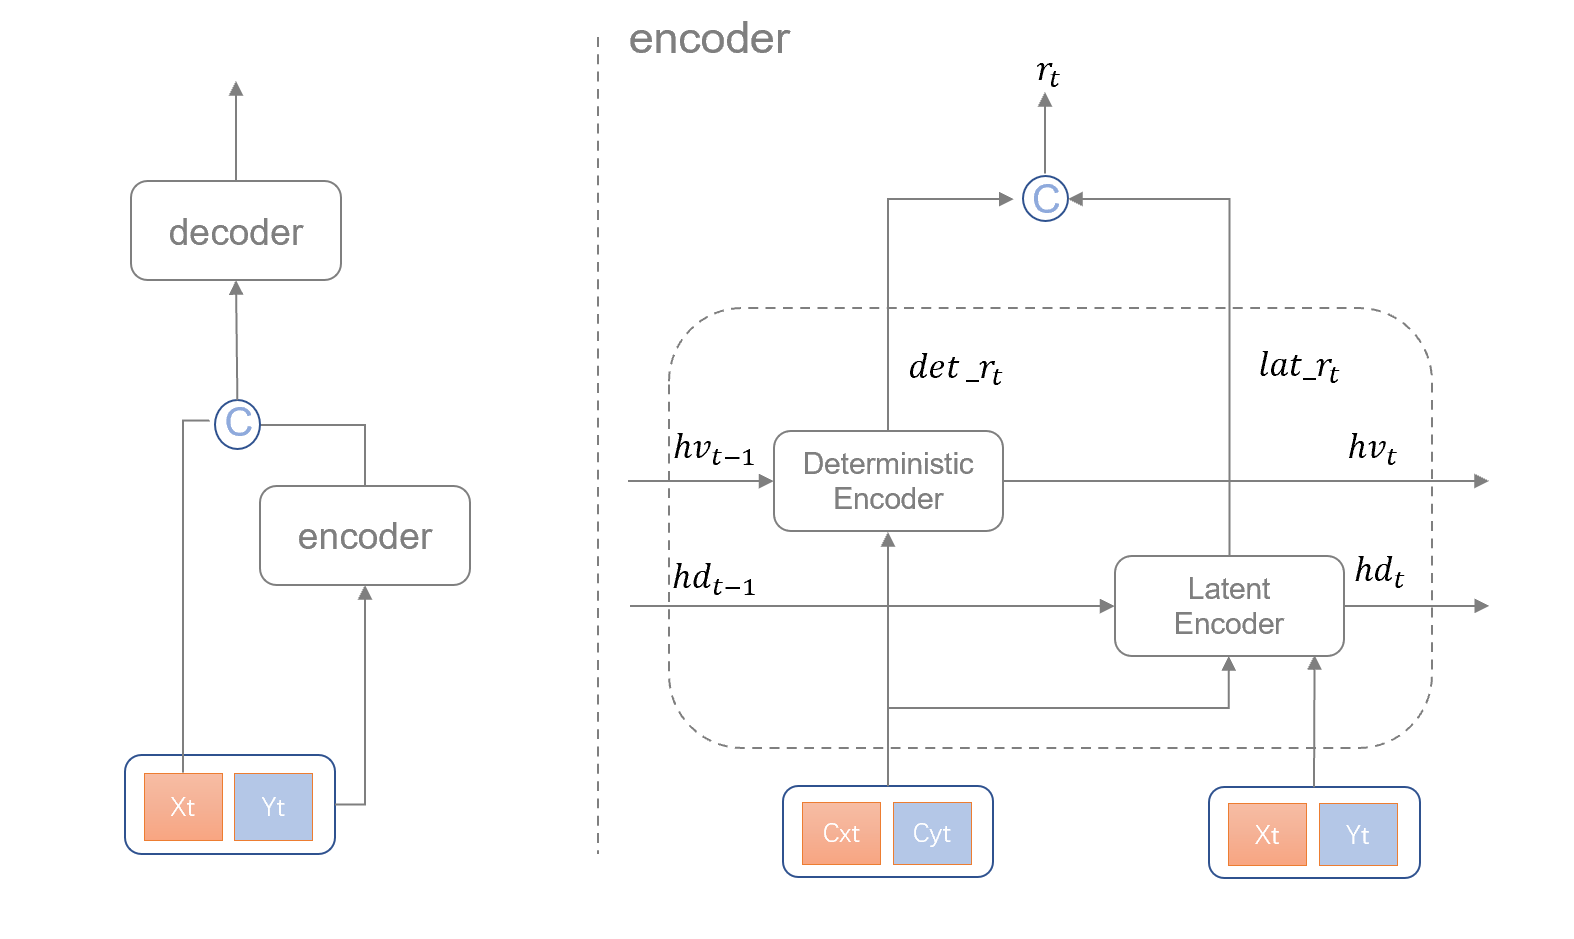 The encoder-decoder scheme SNPs models employ is derived from the design of NPs models. The model diagrams of NPs(left) and ANPs(right) are listed below.[[1]](https://github.com/deepmind/neural-processes/blob/master/attentive_neural_process.ipynb)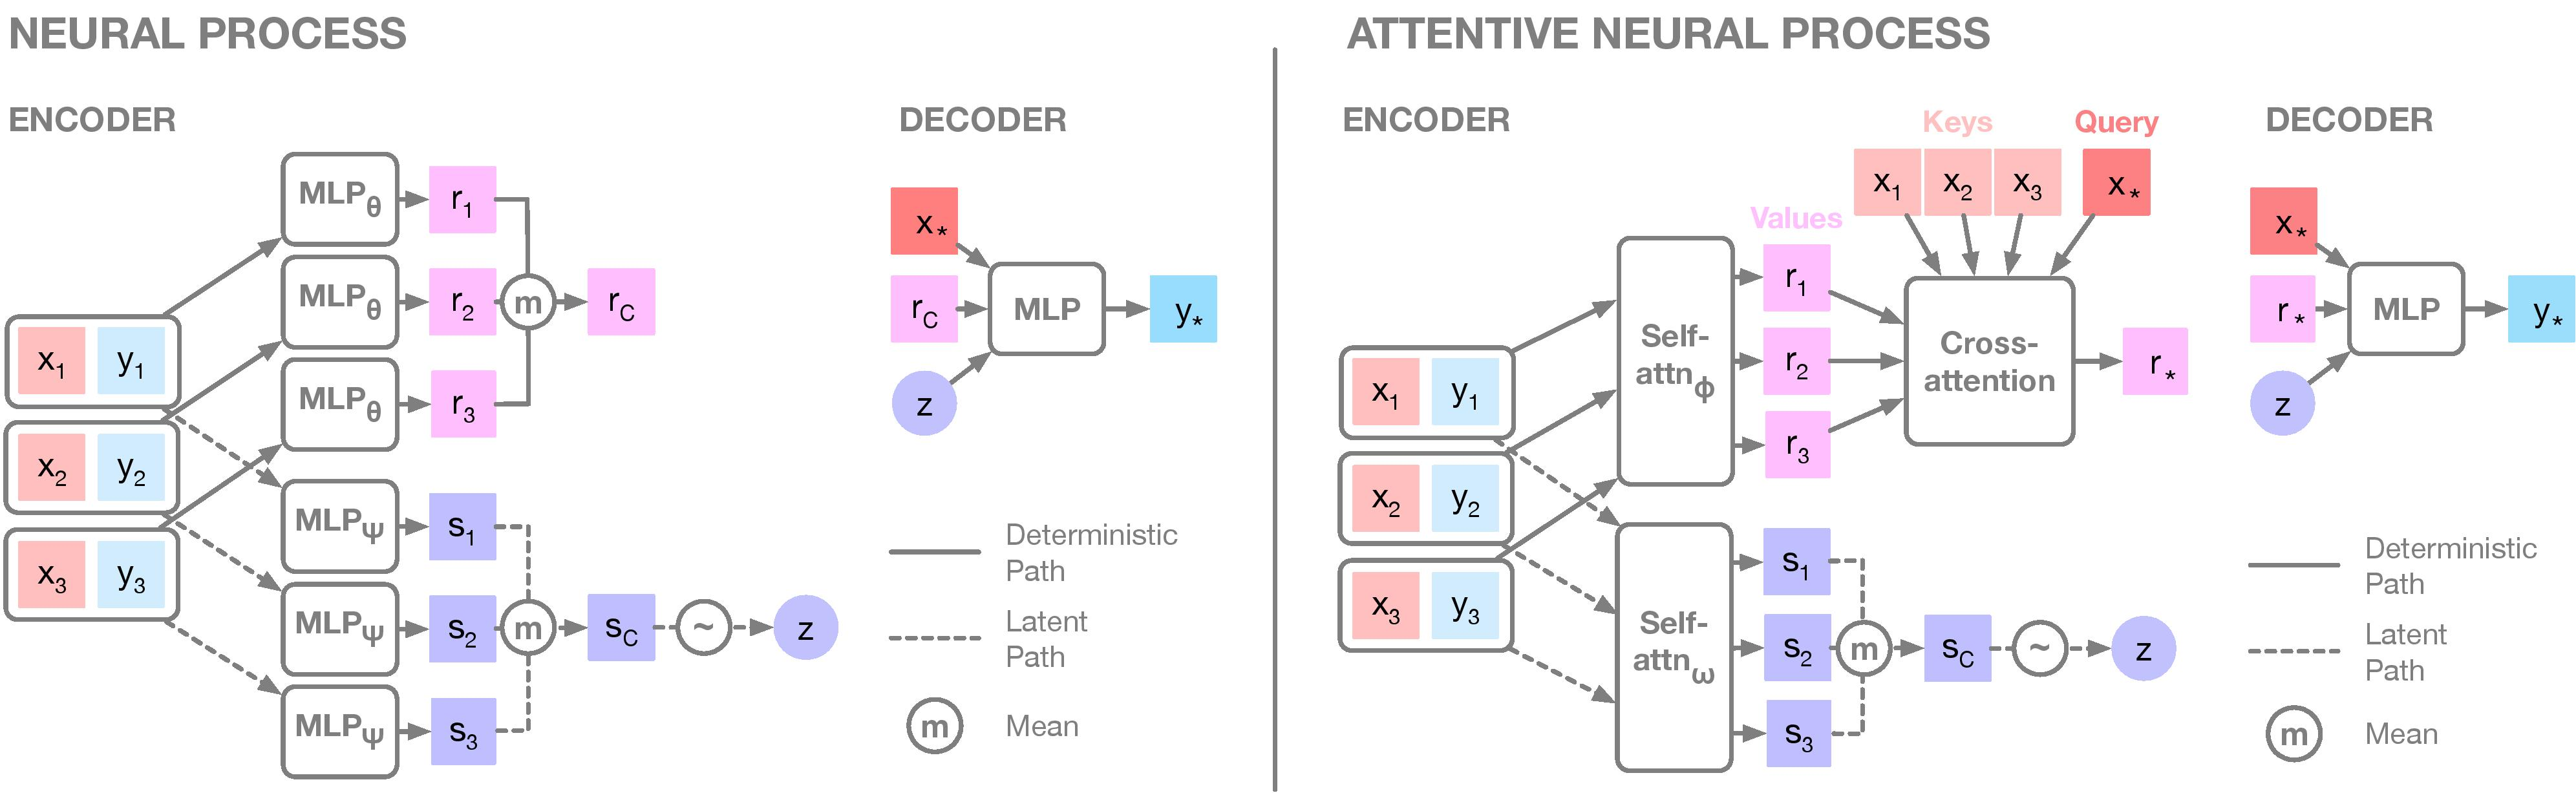
Note that the NPs utilized in SNPs models is replaceable by ANPs models. The official code of SNPs adopts this setting. Our reimplementation follows the implementation specified in the paper and did not incorporate the cross-attention module into the SNPs model. The following illustration and explanation also takes this vanilla, non-attentive structure of SNPs. 

### Encoder: Deterministic Path
As is shown in the model diagram of NPs, The encoder consists of a **deterministic path** and a **latent path**. Under the recurrent setting of SNPs, the **deterministic path of SNPs encoder** takes the 'deterministic hidden state' from last timestep, and context pairs as inputs, which are then passed through MLPs with the number of context pairs to learn the embeddings and aggregated together(take the mean of embeddings) as the deterministic representation of data. The pytorch implementation of deterministic path is as follows. 

<u>Note that the following code (include all following code blocks) presented in this notebook is extracted from the original scripts for illustration and explanation purpose, and thus may not be runnable in the notebook environment.</u>

In [ ]:
def deterministic_encode(self, cxt_x, cxt_y, drnn_h, num_trgts, num_cxt_pnt=0, get_hidden=False, given_hidden=None, attention=None, trgt_x=None):
    # the argument trgt_x is obsolete
    if given_hidden is None:
        x_y = torch.cat([cxt_x, cxt_y], dim=-1)
        if x_y.shape[1] == 0:
            assert num_cxt_pnt==0, "inconsistent context point number"
        hidden = F.relu(self.det_enc_1(x_y))
        hidden = F.relu(self.det_enc_2(hidden))
        hidden = F.relu(self.det_enc_3(hidden))
        # hidden = torch.nn.ModuleList(hidden)
        if get_hidden:
            # return raw hidden tensor, without temporal information
            return hidden
    else:
        hidden = given_hidden
    # incorporate temporal state
    hidden = torch.mean(hidden, dim=1, keepdim=True).repeat([1, num_trgts, 1])
    drnn_h = torch.unsqueeze(drnn_h, axis=1).repeat([1, num_trgts, 1])
    hidden = drnn_h if num_cxt_pnt==0 else hidden+drnn_h

    return hidden

### Encoder: Latent Path
The basic structure of latent path in the encoder is similar to the deterministic path. The difference between two path is that one extra MLP is applied to the aggregated representation to compute the mean and variance of the conditional Gaussian distribution. The latent path of SNPs applys one additional branch to get the hidden state of the latent path, as opposed to the original NPs. 

In [ ]:
def latent_encode(self, x, y, vrnn_h, num_cxt_pnt=0, get_hidden=False, given_hidden=None):
    if given_hidden is None: 
        x_y = torch.cat([x, y], dim=-1)
        hidden = F.relu(self.lat_enc_1(x_y))
        hidden = F.relu(self.lat_enc_2(hidden))
        hidden = F.relu(self.lat_enc_3(hidden))
        # last layer without ReLU, supplemented
        hidden = self.lat_enc_5(hidden)
        # hidden = torch.nn.ModuleList(hidden)

        if get_hidden:
            return hidden
    else:
        hidden = given_hidden

    # aggregator
    hidden = torch.mean(hidden, dim=1)
    hidden = torch.zeros(x.shape[0], self.num_latents).to(torch.device("cuda")) if num_cxt_pnt==0 else hidden
    # incorporate temporal state
    hidden += vrnn_h

    hidden = F.relu(self.lat_enc_4(hidden))
    mu = self.r_to_z_mean(hidden)
    # mu = torch.nn.ModuleList(mu)
    log_sigma = self.r_to_z_log_sigma(hidden)
    # log_sigma = torch.nn.ModuleList(log_sigma)

    return mu, log_sigma

### Decoder
The decoder takes the target inputs and the overall representation of context from the encoder, concatenates the two inputs, and passes the resulting tensor through and MLP. The MLP outputs the mean and variance of the Gaussian distribution over the target points. The implementation here is identical to the NPs implementation. 

In [ ]:
def decode(self, representation, trgt_x):
    hidden = torch.cat([representation, trgt_x], dim=-1)
    hidden = F.relu(self.dec_1(hidden))
    hidden = self.dec_2(hidden)
    # get mean and variance
    # print(hidden.shape)
    mu, log_sigma = torch.split(hidden, 1, dim=-1)
    # bound variance
    sigma = 0.1 + 0.9 * torch.nn.Softplus()(log_sigma)
    # get the distribution
    dist = torch.distributions.Normal(loc=mu, scale=sigma)

    return dist, mu, sigma

Combining the aforementioned blocks within a recurrent structure, we can form the whole SNPs model with the following code. 

In [ ]:
import os
import argparse
import random
import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

class SNP(nn.Module):
    def __init__(self, args):
        super(SNP, self).__init__()
        # hyperparams
        self._beta = args.beta
        self.num_latents = args.num_latents
        self.latent_encoder_output_sizes = args.latent_encoder_output_sizes
        self.deterministic_encoder_output_sizes=args.deterministic_encoder_output_sizes
        # an important one: size of global representation from encoder
        self.representation_size = args.representation_size
        # above; to be determined
        self.decoder_output_sizes = args.decoder_output_sizes
                
        # latent encoder layers
        # 1-d dataset, input: [batch_size, (x_cxt, y_cxt)] 
        self.lat_enc_1 = nn.Linear(2, 128)
        self.lat_enc_2 = nn.Linear(128, 128)
        self.lat_enc_3 = nn.Linear(128, 128)
        # after adding vrnn_h to latent_encoding
        self.lat_enc_4 = nn.Linear(128, 128)
        self.lat_enc_5 = nn.Linear(128, 128)

        # deterministic encoder layers
        self.det_enc_1 = nn.Linear(2, 128)
        self.det_enc_2 = nn.Linear(128, 128)
        self.det_enc_3 = nn.Linear(128, self.deterministic_encoder_output_sizes[-1])

        # latent_encoding sampling layers
        self.r_to_z_mean = nn.Linear(self.latent_encoder_output_sizes[-1], self.num_latents)
        self.r_to_z_log_sigma = nn.Linear(self.latent_encoder_output_sizes[-1], self.num_latents)

        # decoder layers
        self.dec_1 = nn.Linear(self.representation_size + 1, 128)
        self.dec_2 = nn.Linear(128, 2)   

        # recurrent layers
        self._drnn = nn.LSTMCell(input_size=128, hidden_size=self.num_latents)
        self._vrnn = nn.LSTMCell(input_size=128, hidden_size=self.num_latents)

        # unseen/seen plots
        self._index = torch.Tensor(np.arange(0,2000)).to(torch.device("cuda"))

        # attention layers
        # TBD

    def reparameterise(self, z, num_trgt_t):
        mu, logvar = z
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_sample = eps.mul(std).add_(mu)
        z_sample = z_sample.unsqueeze(1).expand(-1, num_trgt_t, -1)
        return z_sample

    def latent_encode(self, x, y, vrnn_h, num_cxt_pnt=0, get_hidden=False, given_hidden=None):
        if given_hidden is None: 
            x_y = torch.cat([x, y], dim=-1)
            hidden = F.relu(self.lat_enc_1(x_y))
            hidden = F.relu(self.lat_enc_2(hidden))
            hidden = F.relu(self.lat_enc_3(hidden))
            # last layer without ReLU, supplemented
            hidden = self.lat_enc_5(hidden)
            # hidden = torch.nn.ModuleList(hidden)
        
            if get_hidden:
                return hidden
        else:
            hidden = given_hidden
        
        # aggregator
        hidden = torch.mean(hidden, dim=1)
        hidden = torch.zeros(x.shape[0], self.num_latents).to(torch.device("cuda")) if num_cxt_pnt==0 else hidden
        # incorporate temporal state
        hidden += vrnn_h

        hidden = F.relu(self.lat_enc_4(hidden))
        mu = self.r_to_z_mean(hidden)
        # mu = torch.nn.ModuleList(mu)
        log_sigma = self.r_to_z_log_sigma(hidden)
        # log_sigma = torch.nn.ModuleList(log_sigma)

        return mu, log_sigma
    
    def deterministic_encode(self, cxt_x, cxt_y, drnn_h, num_trgts, num_cxt_pnt=0, get_hidden=False, given_hidden=None, attention=None, trgt_x=None):
        # the argument trgt_x is obsolete
        if given_hidden is None:
            x_y = torch.cat([cxt_x, cxt_y], dim=-1)
            if x_y.shape[1] == 0:
                assert num_cxt_pnt==0, "inconsistent context point number"
            hidden = F.relu(self.det_enc_1(x_y))
            hidden = F.relu(self.det_enc_2(hidden))
            hidden = F.relu(self.det_enc_3(hidden))
            # hidden = torch.nn.ModuleList(hidden)
            if get_hidden:
                # return raw hidden tensor, without temporal information
                return hidden
        else:
            hidden = given_hidden
        # incorporate temporal state
        hidden = torch.mean(hidden, dim=1, keepdim=True).repeat([1, num_trgts, 1])
        drnn_h = torch.unsqueeze(drnn_h, axis=1).repeat([1, num_trgts, 1])
        hidden = drnn_h if num_cxt_pnt==0 else hidden+drnn_h

        return hidden
    
    def decode(self, representation, trgt_x):
        hidden = torch.cat([representation, trgt_x], dim=-1)
        hidden = F.relu(self.dec_1(hidden))
        hidden = self.dec_2(hidden)
        # get mean and variance
        # print(hidden.shape)
        mu, log_sigma = torch.split(hidden, 1, dim=-1)
        # bound variance
        sigma = 0.1 + 0.9 * torch.nn.Softplus()(log_sigma)
        # get the distribution
        dist = torch.distributions.Normal(loc=mu, scale=sigma)

        return dist, mu, sigma

    def forward(self, query, trgt_y, num_trgts, num_cxt_pnts):
        (cxt_x, cxt_y), trgt_x = query
        len_seq = len(cxt_x)
        batch_size = cxt_x[0].shape[0]
        
        # latent rnn state initialization
        lat_h_0 = torch.zeros(batch_size, self.num_latents).to(torch.device("cuda"))
        lat_c_0 = torch.zeros(batch_size, self.num_latents).to(torch.device("cuda"))
        vrnn_h, vrnn_c = lat_h_0, lat_c_0
        latent_rep = vrnn_h

        # deterministic rnn state initialization
        det_h_0 = torch.zeros(batch_size, self.num_latents).to(torch.device("cuda"))
        det_c_0 = torch.zeros(batch_size, self.num_latents).to(torch.device("cuda"))
        drnn_h, drnn_c = det_h_0, det_c_0
        avg_det_rep = drnn_h

        # loss components
        trgt_dist_list, trgt_mu_list, trgt_sigma_list = [], [], []
        trgt_mu_n_sigma = {"mu":[], "sigma":[]}
        # encoder distribution list
        prior_dist = {"mu":[], "log_sigma":[]}
        post_dist = {"mu":[], "log_sigma":[]}

        # recurrent loop
        for t in range(len_seq):
            cxt_x_t = cxt_x[t]
            cxt_y_t = cxt_y[t]
            trgt_x_t = trgt_x[t]
            trgt_y_t = trgt_y[t]
            
            # 1.1 latent encoding
            lat_en_c = self.latent_encode(cxt_x_t, cxt_y_t, vrnn_h, get_hidden=True)
            lat_en_c_mean = torch.mean(lat_en_c, dim=1)
            latent_rep = latent_rep if num_cxt_pnts[t] == 0 else latent_rep + lat_en_c_mean
            vrnn_h, vrnn_c = self._vrnn(latent_rep, (vrnn_h, vrnn_c))
            # pull these out of the if-else clause for loss components calculation
            post_mu, post_log_sigma = self.latent_encode(trgt_x_t, trgt_y_t, vrnn_h, num_cxt_pnts[t])
            prior_mu, prior_log_sigma = self.latent_encode(cxt_x_t, cxt_y_t, vrnn_h, num_cxt_pnts[t], given_hidden=lat_en_c)

            if self.training:
                # assert trgt_y, "tar_y is empty"
                latent_rep = self.reparameterise((post_mu, post_log_sigma), num_trgts[t])
            else:
                latent_rep = self.reparameterise((prior_mu, prior_log_sigma), num_trgts[t])

            # 1.2 deterministic encoding
            det_en_c = self.deterministic_encode(cxt_x_t, cxt_y_t, drnn_h, num_trgts[t], num_cxt_pnts[t], get_hidden=True)
            det_en_c_mean = torch.mean(det_en_c, dim=1)
            avg_det_rep = avg_det_rep if num_cxt_pnts[t] == 0 else avg_det_rep + det_en_c_mean
            drnn_h, drnn_c = self._drnn(avg_det_rep, (drnn_h, drnn_c))
            deterministic_rep = self.deterministic_encode(cxt_x_t, cxt_y_t, drnn_h, num_trgts[t], num_cxt_pnts[t], given_hidden=det_en_c)
            # avg_det_rep = torch.mean(deterministic_rep, dim=1)

            # 1.3 representation merging
            representation = torch.cat([deterministic_rep, latent_rep], dim=-1)
            latent_rep = torch.mean(latent_rep, dim=1)

            # 2.1 decoding
            dist, mu, sigma = self.decode(representation, trgt_x_t)
            
            # output sort-out
            trgt_dist_list.append(dist)
            trgt_mu_n_sigma["mu"].append(mu)
            trgt_mu_n_sigma["sigma"].append(sigma)
            
            prior_dist["mu"].append(prior_mu)
            prior_dist["log_sigma"].append(prior_log_sigma)
            post_dist["mu"].append(post_mu)
            post_dist["log_sigma"].append(post_log_sigma)

        return trgt_dist_list, trgt_mu_n_sigma, prior_dist, post_dist
 

### Loss
The loss of SNPs model is similar to that of NPs model, consisting of two parts: the posterior estimation error(negative log-likelihood between predicted target y and ground truth) and the KL divergence between distribution over context points and distribution over target points (loss derived from ELBO in variational inference). 

Note that in practice the KL term can make the KL divergence term in loss function collapse as the transition relies more on previous context latents while ignoring the context points at current timestep. In the paper, the technique ***posterior dropout* ELBO** is introduced where a subset of timesteps is selected for which the context latents are sampled using the prior transition, while for the remaining timesteps the context latents are sampled using the posterior transition.  

In [ ]:
def snp_loss(self, trgt_dist_list, trgt_mu_n_sigma, prior_dists, post_dists, len_seq, trgt_ys):
    log_p_list, kl_list = [], []

    for t in range(len_seq):
        dist = trgt_dist_list[t]
        trgt_y_t = trgt_ys[t]
        prior_mu, prior_log_sigma = prior_dists["mu"][t], prior_dists["log_sigma"][t]
        post_mu, post_log_sigma = post_dists["mu"][t], post_dists["log_sigma"][t]
        trgt_mu = trgt_mu_n_sigma["mu"][t]

        # 2.2.1 ELBO/log_prob | TrgtNLL/NLL
        log_p = -torch.mean(dist.log_prob(trgt_y_t))
        log_p_list.append(log_p)

        # 2.2.2 ELBO/kl
        kl = -0.5*(-prior_log_sigma+post_log_sigma \
                    - (torch.exp(post_log_sigma)+(post_mu-prior_mu)**2) \
                    / torch.exp(prior_log_sigma) + 1.0)
        kl = torch.mean(kl, dim=-1, keepdims=True)
        kl_list.append(torch.mean(kl))

    log_p = np.sum(log_p_list) / len(log_p_list)
    kl = np.sum(kl_list) / len(kl_list)

    # final loss
    loss = log_p + self._beta * kl

    return loss

## SNP for 1D Regression Task
The dataset for the regression task is generated from a data generator which generates sequences of functions each of which is drawn from a Gaussian process with squared-exponential kernels. For temporal dynamics between consecutive functions in the sequence, the kernel hyper-parameters are changed with an update function and an additional Gaussian noise for stochasticity. Note that during the re-implementation of the data generator, the singularity of the kernel matrix is occasionally disrupted and cause the following errors during conducting cholesky decomposition of the kernel. In order to resolve this instability issue, the variance of the noise is bumped up. 

Three sub-tasks of the regression task is conducted, as is stated in the paper. In **task (a)**, context points are provided in a limited frame of timesteps in order to observe how the transition model generalize over time. In **task (b)**, the context are intermittently provided in randomly selecting timesteps to see how the model incorporates new context information and updates its belief about the time-evloving function. In **task (c)**, the context size is shrunk to 1 and provided in randomly selected timesteps (45 out of 50) to test how the highly partial observations are accumulated and retained over a long term. 

In [ ]:
import collections
import numpy as np
import torch
from tqdm import tqdm
from scipy import linalg

SNPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "trgt_y", "num_tot_pnts", "num_cxt_pnts", "hyperparams")
)

def custom_matrix_cholesky(A):
    L = torch.zeros_like(A)

    for i in range(A.shape[-1]):
        for j in range(i+1):
            s = 0.0
            for k in range(j):
                s = s + L[i,k] * L[j,k]

            L[i,j] = torch.sqrt(A[i,i] - s) if (i == j) else \
                      (1.0 / L[j,j] * (A[i,j] - s))
    return L

def cholesky_with_exception_handle(x, upper=False, force_iterative=False):
    # ****** OBSOLETE ******
    success = False
    if not force_iterative:
        try:
            results = torch.cholesky(x, upper=upper)
            success = True
        except RuntimeError as e:
            print(str(e)+", bypassing exception by custom cholesky impl.")

    if not success:
        # fall back to operating on each element separately
        results_list = []
        x_batched = x.reshape(-1, x.shape[-2], x.shape[-1])
        print("batch_id: ", end="")
        for batch_idx in range(x_batched.shape[0]):
            try:
                result = torch.cholesky(x_batched[batch_idx, :, :], upper=upper)
            except RuntimeError:
                result = custom_matrix_cholesky(x_batched[batch_idx, :, :])
            results_list.append(result)
            print(batch_idx, end=" ")
        results = torch.cat(results_list, dim=0).reshape(*x.shape)
        print("\nbatch-elem-wise cholesky decomposition impl done.")

    return results

class GPCurvesReader(object):
    def __init__(self, batch_size, max_num_cxt, 
                x_size=1, y_size=1,
                len_seq=10, len_given=5, len_gen=10, 
                l1_min=0.7, l1_max=1.2, l1_vel=0.05, 
                sigma_min=1.0, sigma_max=1.6, sigma_vel=0.05,
                testing=False, task_type=1):
        # task_type: refer to task(a), task(b), task(c) from SNP paper
        # remove temporal argm from original generator, since no longer considering NP structure
        self._batch_size = batch_size
        self._max_num_cxt = max_num_cxt
        # x_size and y_size are both 1 since the data is 1d data
        self._x_size = x_size
        self._y_size = y_size
        self._len_seq = len_seq
        self._len_given = len_given
        self._len_gen = len_gen
        self._l1_min = l1_min
        self._l1_max = l1_max
        self._l1_vel = l1_vel
        self._sigma_min = sigma_min
        self._sigma_max = sigma_max
        self._sigma_vel = sigma_vel
        self._task_type = task_type
        self._testing = testing

        self._noise_factor = 0.1
    
    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=5e-2):
        # **increase the default sigma_noise to avoid singular kernel issue***

        # xtata: [batch_size, num_tot_pnts, x_size]
        num_tot_pnts = xdata.shape[1]

        xdata1 = torch.unsqueeze(xdata, dim=1)
        xdata2 = torch.unsqueeze(xdata, dim=2)
        diff = xdata1 - xdata2
        norm = torch.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])
        norm = torch.sum(norm, dim=-1, keepdim=False)

        kernel = torch.square(sigma_f)[:, :, None, None] * torch.exp(-0.5*norm)
        kernel += (sigma_noise**2) * torch.eye(num_tot_pnts)

        return kernel
    
    def generate_curves(self, l1, sigma_f, 
                        num_cxt=3, y_val_base=None, seed=None):
        if seed:
                torch.manual_seed(seed)
                torch.cuda.manual_seed(seed)
        if self._testing:
            num_tot_pnts = 400
            num_trgts = num_tot_pnts
            x_vals = torch.unsqueeze(torch.range(-4., 4., 1./50, dtype=torch.float32)[:-1], dim=0).repeat([self._batch_size, 1])
        else:
            num_tot_pnts = 100
            maxval = self._max_num_cxt - num_cxt + 1
            num_trgts = torch.randint(low=1, high=int(maxval), size=[1], dtype=torch.int32)
            x_vals = torch.unsqueeze(torch.range(-4., 4., 1./12.5, dtype=torch.float32)[:-1], dim=0).repeat([self._batch_size, 1])
        x_vals = torch.unsqueeze(x_vals, dim=-1)
        # kernel: [batch_size, y_size, num_tot_pnts, num_tot_pnts]
        kernel = self._gaussian_kernel(x_vals, l1, sigma_f)
        cholesky = torch.cholesky(kernel.type(torch.float64)).type(torch.float32)

        # sample a curve
        # y_vals: [batch_size, num_tot_pnts, y_size]
        y_vals = torch.matmul(cholesky, y_val_base)
        y_vals = torch.squeeze(y_vals, dim=3).permute([0, 2, 1])

        if self._testing:
            trgt_x = x_vals
            trgt_y = y_vals

            # select observations
            idx = torch.range(0, num_trgts)[:-1].type(torch.int64)
            idx = idx[torch.randperm(idx.shape[0])]
            cxt_x = torch.index_select(x_vals, 1, idx[:num_cxt])
            cxt_y = torch.index_select(y_vals, 1, idx[:num_cxt])
        else:
            idx = torch.range(0, num_tot_pnts)[:-1].type(torch.int64)
            trgt_x = torch.index_select(x_vals, 1, idx[:num_trgts+num_cxt])
            trgt_y = torch.index_select(y_vals, 1, idx[:num_trgts+num_cxt])

            # select observations
            cxt_x = torch.index_select(x_vals, 1, idx[:num_cxt])
            cxt_y = torch.index_select(y_vals, 1, idx[:num_cxt])
        
        query = ((cxt_x, cxt_y), trgt_x)

        return SNPRegressionDescription(
            query=query,
            trgt_y=trgt_y,
            num_tot_pnts=trgt_x.shape[1],
            num_cxt_pnts=num_cxt,
            hyperparams=torch.Tensor([0])
        )

    def generate_temporal_curves(self, seed=None):
        if seed:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)

        # set kernel params
        l1 = self._l1_min * torch.ones([self._batch_size, self._y_size, self._x_size]) \
            + torch.rand([self._batch_size, self._y_size, self._x_size])*(self._l1_max-self._l1_min)
        sigma_f = self._sigma_min * torch.ones([self._batch_size, self._y_size]) \
                + torch.rand([self._batch_size, self._y_size])*(self._sigma_max-self._sigma_min)
        l1_vel = -1 * self._l1_min * torch.ones([self._batch_size, self._y_size, self._x_size]) \
            + torch.rand([self._batch_size, self._y_size, self._x_size])*(2*self._l1_vel)
        sigma_f_vel = -1 * self._sigma_min * torch.ones([self._batch_size, self._y_size]) \
                + torch.rand([self._batch_size, self._y_size])*(2*self._sigma_vel)
        
        if self._testing:
            num_tot_pnts = 400
        else:
            num_tot_pnts = 100
        y_val_base = torch.zeros([self._batch_size, self._y_size, num_tot_pnts, 1]).normal_()

        curve_list = []
        if self._task_type==2 or self._task_type==3:
            idx = torch.range(0, self._len_seq)[:-1].type(torch.int64)
            idx = idx[torch.randperm(idx.shape[0])][:self._len_given]
        
        for t in tqdm(range(self._len_seq), desc="main temporal GP context generation"):
            if seed:
                seed_t = seed * t
                torch.manual_seed(seed_t)
                torch.cuda.manual_seed(seed_t)
            else:
                seed_t = seed
            if self._task_type == 1:
                # 10 context points, 20 total points
                if t < self._len_given:
                    num_cxt = torch.randint(low=5, high=self._max_num_cxt, size=[1], dtype=torch.int32)
                else:
                    num_cxt = torch.Tensor([0]).type(torch.int32)
            if self._task_type == 2:
                # sprinkled context points
                nc_cond = torch.where(torch.eq(idx, t))[0]
                num_cxt = torch.Tensor([0]).type(torch.int32) if nc_cond.shape[0]==0 \
                            else torch.randint(low=5, high=self._max_num_cxt, size=[1], dtype=torch.int32)
            if self._task_type == 3:
                # long term tracking
                nc_cond = torch.where(torch.eq(idx, t))[0]
                num_cxt = torch.Tensor([0]).type(torch.int32) if nc_cond.shape[0]==0 \
                            else torch.Tensor([1]).type(torch.int32)
            curve_list.append(self.generate_curves(l1, sigma_f, num_cxt,
                                                    y_val_base, seed_t))
            vel_noise = l1_vel * self._noise_factor \
                        * torch.zeros([self._batch_size, self._y_size, self._x_size]).normal_()
            l1 += l1_vel + vel_noise
            vel_noise = sigma_f_vel * self._noise_factor \
                        * torch.zeros([self._batch_size, self._x_size]).normal_()
            sigma_f += sigma_f_vel + vel_noise
        
        if self._testing:
            for t in tqdm(range(self._len_seq, self._len_seq+self._len_gen), desc="testing temporal GP targets generation"):
                if seed:
                    seed_t = seed * t
                    torch.manual_seed(seed_t)
                    torch.cuda.manual_seed(seed_t)
                else:
                    seed_t = seed
                num_cxt = torch.Tensor([0]).type(torch.int32)
                curve_list.append(self.generate_curves(l1, sigma_f, num_cxt,
                                                    y_val_base, seed_t))
                vel_noise = l1_vel * self._noise_factor \
                        * torch.zeros([self._batch_size, self._y_size, self._x_size]).normal_()
                l1 += l1_vel + vel_noise
                vel_noise = sigma_f_vel * self._noise_factor \
                            * torch.zeros([self._batch_size, self._x_size]).normal_()
                sigma_f += sigma_f_vel + vel_noise
        
        cxt_x_list, cxt_y_list = [], []
        trgt_x_list, trgt_y_list = [], []
        num_total_points_list = []
        num_cxt_pnts_list = []

        for t in range(len(curve_list)):
            (cxt_x, cxt_y), trgt_x = curve_list[t].query
            trgt_y = curve_list[t].trgt_y
            num_total_points_list.append(curve_list[t].num_tot_pnts)
            num_cxt_pnts_list.append(curve_list[t].num_cxt_pnts)
            cxt_x_list.append(cxt_x)
            cxt_y_list.append(cxt_y)
            trgt_x_list.append(trgt_x)
            trgt_y_list.append(trgt_y)

        query = ((cxt_x_list, cxt_y_list), trgt_x_list)
        return SNPRegressionDescription(
            query=query,
            trgt_y=trgt_y_list,
            num_tot_pnts=num_total_points_list,
            num_cxt_pnts=num_cxt_pnts_list,
            hyperparams=[torch.Tensor([0])])         


## SNP Model Training
The SNP model is trained on the dataset generated from the aforementioned data generator. The hyperparameters including *MAX_CXT_PNTS*, *HIDDEN_SIZE* follows the setting in the official code. The hyperparameter *TRAINING_ITERATIONS* is set to be lower than the original setting given the limited time frame and available computation power. The script provides terminal support to alter the hyperparameters regarding the training and dataset generations. 

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx in range(100):
        query, trgt_y, num_tot_pnts, num_cxt_pnts, _ = data_train[batch_idx]
        (cxt_x, cxt_y), trgt_x = query
        new_cxt_x, new_cxt_y, new_trgt_x, new_trgt_y = [], [], [], []
        for ta, tb, tc, td in zip(cxt_x, cxt_y, trgt_x, trgt_y):
            ta, tb, tc, td = ta.to(device), tb.to(device), tc.to(device), td.to(device)
            new_cxt_x.append(ta)
            new_cxt_y.append(tb)
            new_trgt_x.append(tc)
            new_trgt_y.append(td)

        query = ((new_cxt_x, new_cxt_y), new_trgt_x)
        trgt_y = new_trgt_y

        optimizer.zero_grad()
        trgt_dist_list, trgt_mu_n_sigma, prior_dist, post_dist = model(query, trgt_y, num_tot_pnts, num_cxt_pnts)

        loss = model.snp_loss(trgt_dist_list, trgt_mu_n_sigma, prior_dist, post_dist, args.LEN_SEQ, trgt_y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        writer.add_scalar('Loss/train', loss.item(), batch_idx)

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * 16, 1600,
                    100. * batch_idx / 100,
                    loss.item() / 16))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / 1600))

The training process is recorded using Tensorboard, as the figures below. Due to the occassional fluctuations of server connection, the model is trained with checkpoints saved and loaded in the training process, which causes the presented loss curves to be segmented in the Tensorboard. The loss diagrams below follows the order of task (a) to task(c).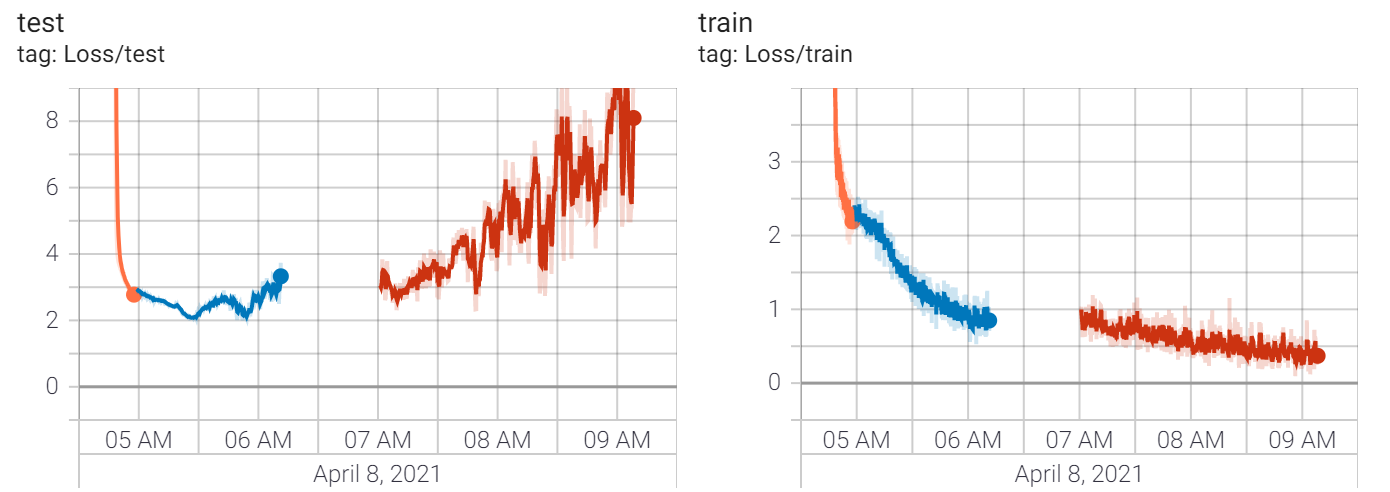

## Results
### task (a)
The figure below presents one test example whose targets are generated from the model given the task (a) test data. <table><tr><td><img src=attachment:task_a_w_cxt_t6.png></td><td><img src=attachment:task_a_pred_t12.png></td></tr></table> The first figure shows the prediction of targets given contexts at *t*=6. The second figure shows the prediction of targets without context points at *t*=12. The given example presents the strong capability of the SNP model. However, despite the good results shown in the figures, the predictions generated without contexts at later timesteps shows a deterioration in the quality, revealing that the relative instability of the model in temporal generalization.  
### task (b)
The figure below shows three consecutive timesteps of model predictions for task (b). <table><tr><td><img src=attachment:taskb_wo_cxt_t5.png></td><td><img src=attachment:taskb_w_cxt_t6.png></td><td><img src=attachment:taskb_wo_cxt_t7.png></td></tr></table>
### task (c)
The figure below shows the generated curves at timesteps *t*=4 and *t*=5, where one or no context point are provided during the prediction. From the figure, this highly partial observation setting can affect the prediction of the model. <table><tr><td><img src=attachment:task_c_w_cxt_t4.png></td><td><img src=attachment:task_c_wo_cxt_t5.png></td></tr></table>
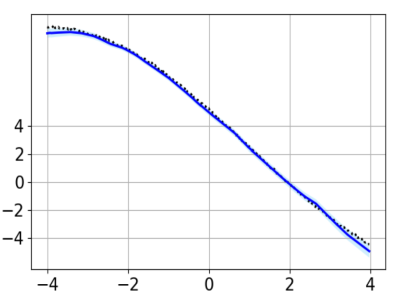
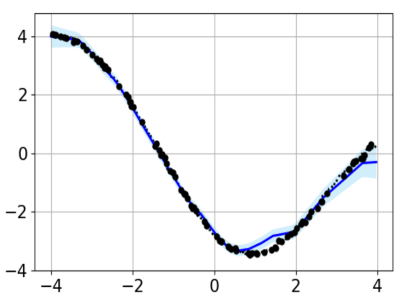
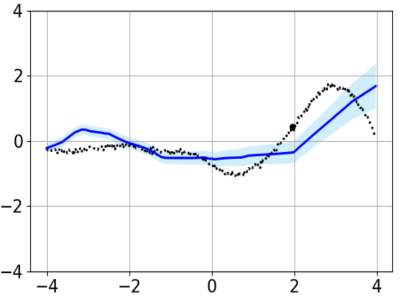
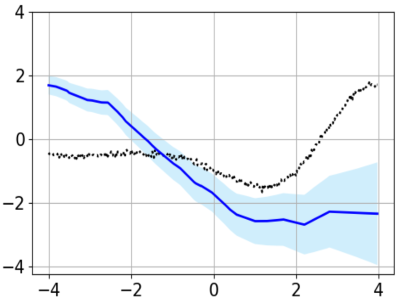
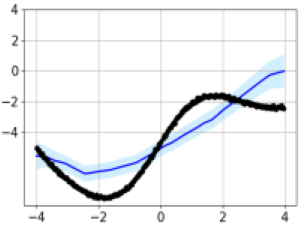
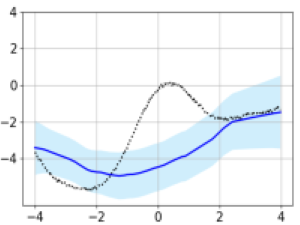
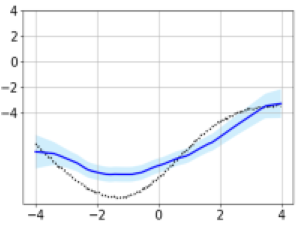

## Miscellaneous
1. The complete testing results with full timesteps are included in the results file in the repository.
2. The checkpoints of trained model parameters and Tensorboard log files recording the training processes are not included in the repository for the sake of space. The main script contains snippets of codes generating corresponding logs and checkpoints.  